# Notebook for UAV Cal/Val experiment in El Socorro 
----

This notebook will perform a step-by-step guide on how to perform a calibration and valitation (Cal/Val) of different UAV-based sensors using vicarious in-situ measurements during UAV overpasses. 

The data were collected on September 19th, 2022 in the El Socorro experimental vineyard farm managed by IMIDRA during PTI TELEDETECT workshop

### Notebook structure: 
0. Create python environment and import libraries
1. Visualize UAV imagery
2. Visualize and preprocess insitu ASD data
3. Extracting UAV data over reference panels
4. Develop empirical line
5. Calibrate and validate imagery based on empirical line

----

Code adapted from a [AET 2024](http://eo.csic.es/aet2024) course led by Juan José Peón | Área de Sistemas de Teledetección | Instituto Nacional de Técnica Aeroespacial (INTA) | jpeogar@inta.es

Original code available here: https://colab.research.google.com/drive/14GBdZ9rsC3nep4FKEVtSN-1VdcnB6kca?usp=sharing 

----

# 0.1 Install libraries and dependencies

First step is to make sure you have all the dependencies. Refer to the readme file to install all dependencies. It also recommended to create a conda environment or make sure all libraries necessary are correctly installed.

## Installation

You should have these programs installed:

* Python and/or [Anaconda](https://www.anaconda.com/download/success). 

Install the requirements either with conda/mamba:

`mamba env create -f environment.yml`

or

`conda env create -f environment.yml`

or 

Make sure you have the required libraries installed:
- jupyter
- notebook
- jupyterlab
- jupyter-book
- gdal
- numpy
- scipy
- pandas
- matplotlib
- geopandas
- pathlib
- scikit-learn


## Run the interactive book
Run the following command to initialize the book:

1. Activate python environment 

`conda activate calval-netops`

2. Initialize jupyter notebook
  
`jupyter notebook uav_calval_socorro.ipynb`

or 

`jupyter lab uav_calval_socorro.ipynb`



# 0.2 Import Libraries	

In [1]:
import numpy as np 
import pandas as pd 
import geopandas as gpd 
from osgeo import gdal 
from pathlib import Path 
import matplotlib.pyplot as plt 
from scipy.stats import linregress


print('libraries imported correctly!')

libraries imported correctly!


# 0.3 Dataset summary

A total of **10 UAV overpasses** were performed on September 19th, 2022, which included **6 multispectral** sensors, **3 thermal infrared** sensors, and **1 hyperspectral** sensor. 

See table below for a summary:

|Sensor|Sensor Type |Group |Flight Time (UTC)   
| :---     | :--- | :---  | :---   
| P4M      |multi | ICMAN  | 08:43
| P4M      |multi | ICMAN  | 09:14
| Sequoia+ |multi | ICA  | 09:42
| Micasense|multi | ICMAN  | 10:24
| Micasense|multi | ICMAN  | 10:51
| P4M|multi | GEOINCA  | 11:29
| H20T|TIR| ICA  | 09:42
| M2EA|TIR| ICMAN  | 11:30
| M2EA|TIR| ICMAN  | 11:40
| Cubert S185|Hyper| EBD  | 11:57

This notebook will use the **Sequoia+ orthomosaic** as an example to perform the cal/val using the empirical line approach based on in-situ ASD measurements over reference panels. 

# 1. Visualize UAV image

/home/vicente/miniconda3/envs/calval-netops/lib/python3.13/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


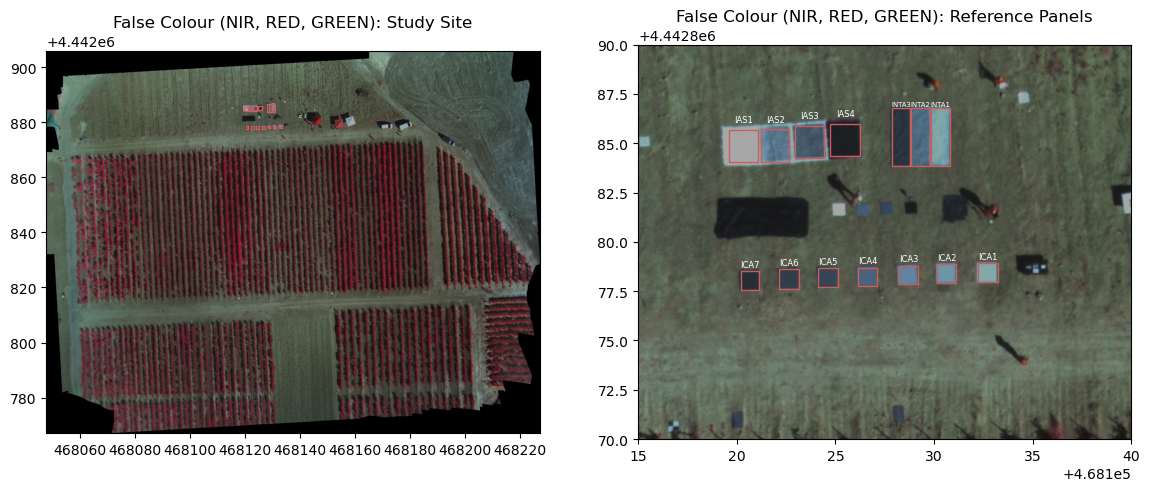

In [2]:
# set work directory (change if the 'dataset' folder is in a different path than the notebook)
workdir = Path()

# sensor name
sensor_name =  'Sequoia_ICA'
uav_dir = workdir / 'dataset' / 'uav_imagery' / 'multi' / sensor_name / 'mosaic'

# shapefile directory 
vector_dir = workdir / 'dataset' / 'vector_data'

# panel outline shapefile 
panels_file = vector_dir/'panels_borders.geojson'

# open as geopandas dataframe
panels_gdf = gpd.read_file(panels_file)

# get orthomosaic file
mosaic_file = uav_dir / 'Mosaic_REF_Sequoia_ICA_0942.tif'

# open as GDAL object
fid = gdal.Open(str(mosaic_file))

# get geotransform and other metadata
geotransform = fid.GetGeoTransform()
minx, maxy = geotransform[0], geotransform[3]
maxx = minx + geotransform[1] * fid.RasterXSize
miny = maxy + geotransform[5] * fid.RasterYSize

# Read specific bands (4=NIR, 3=Red-Edge,2=Red and 1=Green)
nir_band = fid.GetRasterBand(4).ReadAsArray()  # Near-Infrared
rededge_band = fid.GetRasterBand(3).ReadAsArray()  # Red-edge
red_band = fid.GetRasterBand(2).ReadAsArray()  # Red
green_band = fid.GetRasterBand(1).ReadAsArray()  # Green

# Stack the bands to obtain false colour image: R=NIR, G=Red, B=Green
false_color_image = np.dstack((nir_band, red_band, green_band))

# make side by side false colour figure
fig, axes = plt.subplots(1,2, figsize=(14,14))

# whole study area
ax1 = axes[0]
ax1.imshow(false_color_image, extent=[minx, maxx, miny, maxy])
# overlay reference panel borders
panels_gdf.plot(ax=ax1, facecolor='none', edgecolor='indianred', linewidth=1)

ax1.set_title('False Colour (NIR, RED, GREEN): Study Site')

# zoom to reference panels
ax2 = axes[1]
ax2.imshow(false_color_image, extent=[minx, maxx, miny, maxy])
# overlay reference panel borders
panels_gdf.plot(ax=ax2, facecolor='none', edgecolor='indianred', linewidth=1)
# 4. Annotate the plot with labels from the GeoDataFrame
for idx, row in panels_gdf.iterrows():
    # Get the centroid of the geometry (or use point coordinates directly)
    if row.geometry.geom_type == 'Point':
        x, y = row.geometry.x, row.geometry.y  # For points
    else:
        x, y = row.geometry.centroid.x, row.geometry.centroid.y  # For polygons
        
    if row['code'][:-1] == 'INTA':
        # Annotate the map with the 'name' field (or any other attribute)
        ax2.annotate(text=row['code'], xy=(x, y),  xytext=(x, y+1.6), xycoords='data',
                    fontsize=5, ha='center', color='white')
    elif row['code'][:-1] == 'IAS':
        # Annotate the map with the 'name' field (or any other attribute)
        ax2.annotate(text=row['code'], xy=(x, y),  xytext=(x, y+1.2), xycoords='data',
                    fontsize=6, ha='center', color='white')
    else:
        # Annotate the map with the 'name' field (or any other attribute)
        ax2.annotate(text=row['code'], xy=(x, y),  xytext=(x, y+0.7), xycoords='data',
                    fontsize=6, ha='center', color='white')
        
ax2.set_title('False Colour (NIR, RED, GREEN): Reference Panels')
# set xy lim to zoom to panels, change for different zoom extent
ax2.set_xlim(468115,468140)
ax2.set_ylim(4442870,4442890)
plt.show()


# 2. Preprocess ASD data

ASD measurements were acquired over the references panels visible in the right pabnel of the above figure. 

Three different rounds of measuremetns were acquired (R1, R2 and R3)

In [3]:
# get asd file directory
asd_file = workdir / 'dataset' / 'insitu' / 'ASDFieldSpec3_16120_SpecLab' / 'socorro_asd_panels_mean_all.csv' 

# open asd file as a pandas directory
asd_df = pd.read_csv(asd_file)

# show first five rows
#print(asd_df.head())

# get wavelengths as series
wl_asd = asd_df["Wavelength"].values

# get id of all panels (omiting the first column which is the wavelength)
id_panel = asd_df.columns[1:]

# get panel ID to identify the panel type (i.e. INTA1, INTA2, INTA3 etc) i.e. remove round number 'R1', 'R2' etc
id_panel_type = id_panel.str.split('_').map(lambda x: x[0])
# get unique values of ID
panels_unique = id_panel_type.unique()

print(f'Panel IDs:\n{list(id_panel)}\n')
print(f'Panel groups:\n{list(panels_unique)}\n')


Panel IDs:
['ICA1_R1', 'ICA1_R2', 'ICA1_R3', 'ICA2_R1', 'ICA2_R2', 'ICA2_R3', 'ICA3_R1', 'ICA3_R2', 'ICA3_R3', 'ICA4_R1', 'ICA4_R2', 'ICA4_R3', 'ICA5_R1', 'ICA5_R2', 'ICA5_R3', 'ICA6_R1', 'ICA6_R2', 'ICA6_R3', 'ICA7_R1', 'ICA7_R2', 'ICA7_R3', 'INTA1_R1', 'INTA1_R2', 'INTA1_R3', 'INTA2_R1', 'INTA2_R2', 'INTA2_R3', 'INTA3_R1', 'INTA3_R2', 'INTA3_R3', 'IAS1_R1', 'IAS1_R2', 'IAS1_R3', 'IAS2_R1', 'IAS2_R2', 'IAS2_R3', 'IAS3_R1', 'IAS3_R2', 'IAS3_R3', 'IAS4_R1', 'IAS4_R2', 'IAS4_R3']

Panel groups:
['ICA1', 'ICA2', 'ICA3', 'ICA4', 'ICA5', 'ICA6', 'ICA7', 'INTA1', 'INTA2', 'INTA3', 'IAS1', 'IAS2', 'IAS3', 'IAS4']



## 2.1 Visualize ASD data

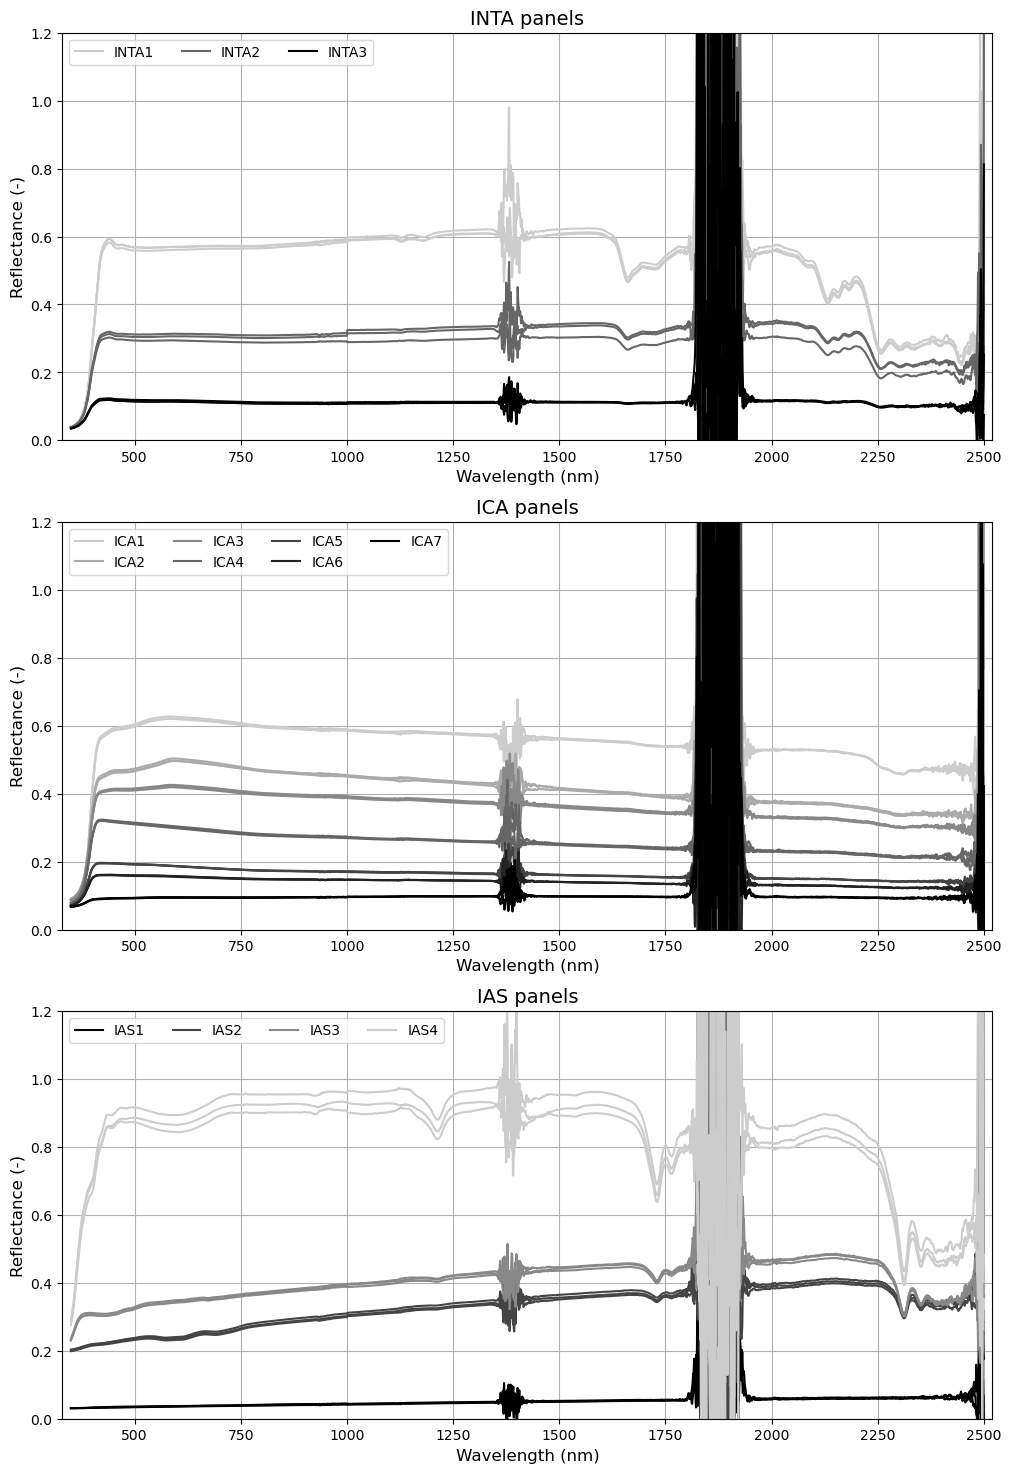

In [4]:
# list of the panels from different groups
panel_groups = ['INTA', 'ICA', 'IAS']

# create 3x1 plot with each panel group 
fig, axes = plt.subplots(3,1, figsize=(12,18))
i = 0
for group in panel_groups:
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    
    # intialize axis
    ax = axes[i]
    ax.set_title(f'{group} panels', fontsize=14)
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_xlim(330, 2520)
    ax.set_ylabel('Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    
    # create light to dark gradient depending on number of panels
    # reverse color gradient for IAS since panel 1 is darkest 
    if group == 'IAS':
        color_gradient = np.linspace(0, 0.8, len(groups_select)).astype(str)
    else:
        color_gradient = np.linspace(0.8, 0, len(groups_select)).astype(str)
    # plot for each panel number
    for n, g in enumerate(groups_select):
      cols = id_panel[id_panel.str.contains(g)]
      panel_number = asd_df[cols]
      # plot each of the spectra (each round)
      for col in panel_number.columns:
        ax.plot(wl_asd, panel_number[col].values, label=g, color=color_gradient[n])
    i = i + 1
    
# create legend for each subplot
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    
    # Create a dictionary to remove duplicates (preserves the first occurrence)
    unique = dict(zip(labels, handles))
    
    # Add the legend with only the unique panel labels and color
    ax.legend(unique.values(), unique.keys(), loc='upper left', ncols = len(groups_select))

plt.show()

## 2.2 convolve ASD spectra using the spectral response function (SRF)

First we need to convolve the ASD measurements (400-2500nm) to the spectral response function of the sensor

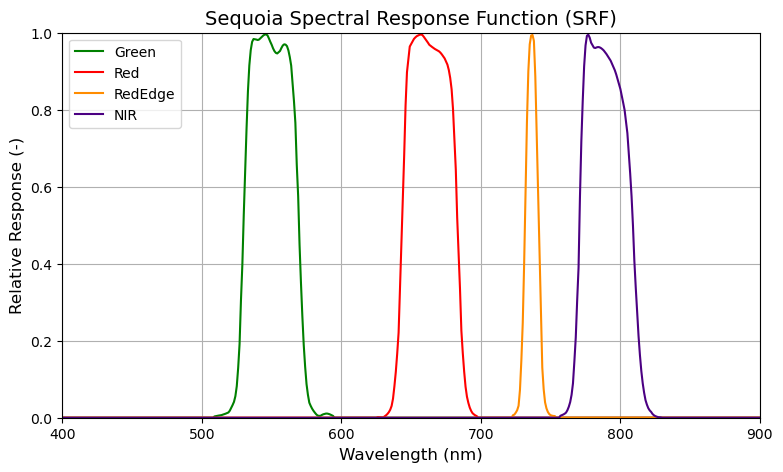

In [5]:
# spectral response function (SRF) file 
srf_file = workdir / 'dataset' / 'uav_imagery' / 'multi' / 'Sequoia_ICA' / 'SRF_Sequoia.txt'

# open as pandas dataframe
srf_df = pd.read_csv(srf_file, sep = '\t')

band_names = srf_df.columns[1:]

# Show spectral response function (SRF) curves
plt.figure(figsize=(9, 5))
plt.title('Sequoia Spectral Response Function (SRF)', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.xlim(400, 900)
plt.ylabel('Relative Response (-)', fontsize=12)
plt.ylim(0, 1)
plt.grid(True)
colors = ['g', 'r', 'darkorange', 'indigo']
i = 0
for band in band_names:
    plt.plot(srf_df['Wavelength_nm'], srf_df[band], color=colors[i], label = str(band))
    i += 1
plt.legend(loc='upper left')
plt.show()

In [6]:
# initialize empty dictionary to store results
asd_convolved_dict = {'panels': []} 

# go through all panels (ICA1, ICA2 etc)
for panel in id_panel:
    asd_data = asd_df[panel]
    # add panel id to output dictonary
    asd_convolved_dict['panels'].append(panel)
    # for each band, apply SRF on ASD spectra
    for band in band_names:
        asd_band = np.sum(asd_data * srf_df[band])/np.sum(srf_df[band])
        # store result in output dictionary
        if band in asd_convolved_dict:
            asd_convolved_dict[band].append(asd_band)
        else:
            asd_convolved_dict[band] = []
            asd_convolved_dict[band].append(asd_band)
            
# convert output dictionary into pandas dataframe
asd_convolved_df = pd.DataFrame(asd_convolved_dict)
asd_convolved_df.head()

panels     Green       Red   RedEdge       NIR
0  ICA1_R1  0.622660  0.620563  0.609648  0.601138
1  ICA1_R2  0.616955  0.615460  0.604666  0.596809
2  ICA1_R3  0.615403  0.614061  0.604646  0.597831
3  ICA2_R1  0.489859  0.495015  0.481341  0.471423
4  ICA2_R2  0.483916  0.489366  0.476379  0.467363

## 2.3 Plot convolved ASD data over reference panels


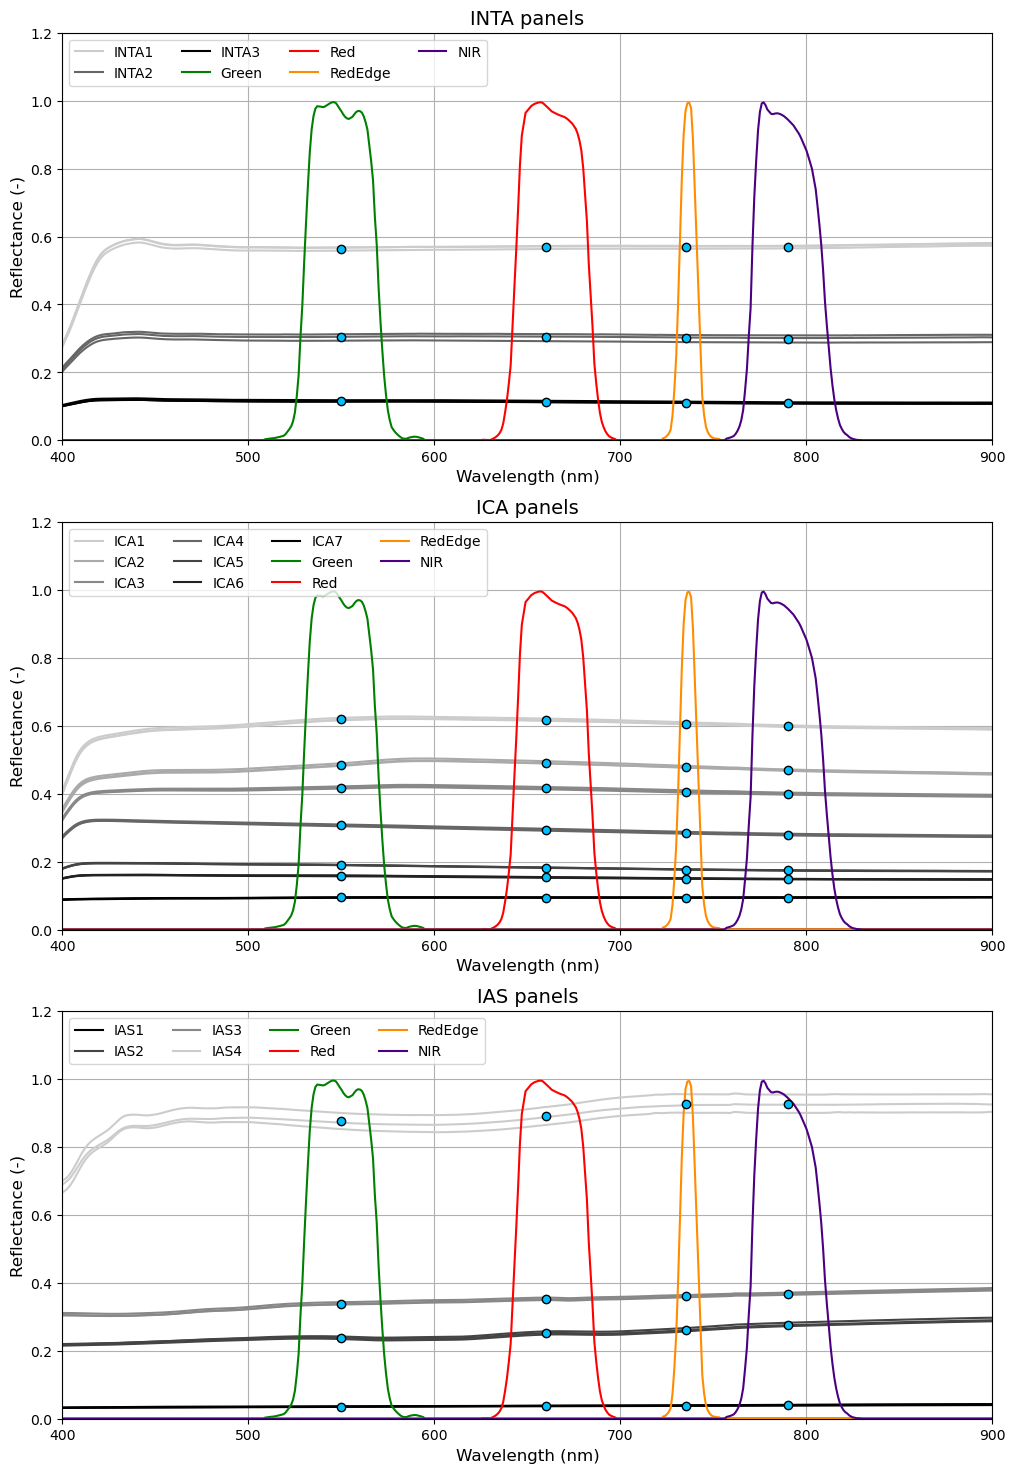

In [7]:
# list of the panels from different groups
panel_groups = ['INTA', 'ICA', 'IAS']

# sensor center wl for each band
sensor_band_center = [550, 660, 735, 790]

# create 3x1 plot with each panel group 
fig, axes = plt.subplots(3,1, figsize=(12,18))
i = 0
for group in panel_groups:
    
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    
    # intialize axis
    ax = axes[i]
    ax.set_title(f'{group} panels', fontsize=14)
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_xlim(400, 900)
    ax.set_ylabel('Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    
    # create light to dark gradient depending on number of panels
    # reverse color gradient for IAS since panel 1 is darkest 
    if group == 'IAS':
        color_gradient = np.linspace(0, 0.8, len(groups_select)).astype(str)
    else:
        color_gradient = np.linspace(0.8, 0, len(groups_select)).astype(str)
    
    # plot for each panel number
    for n, g in enumerate(groups_select):
      cols = id_panel[id_panel.str.contains(g)]
      panel_number = asd_df[cols]
        
      # plot each of the spectra (each round)
      for col in panel_number.columns:
        ax.plot(wl_asd, panel_number[col].values, label=g, color=color_gradient[n])

    # plot spectral response function
    colors = ['g', 'r', 'darkorange', 'indigo']
    n = 0
    for band in band_names:
        ax.plot(srf_df['Wavelength_nm'], srf_df[band], color=colors[n], label = str(band))
        n = n + 1
    # get mean ASD values convolved to Sequoia bands
    for g in groups_select:
        srf_mask = asd_convolved_df['panels'].str.contains(g)
        convolved_values = asd_convolved_df[srf_mask]
        j = 0
        for band in band_names:
            asd_band_values = np.mean(convolved_values[band])
            ax.plot(sensor_band_center[j], asd_band_values, 'o', ms=6, c='black', mfc='deepskyblue')
            j = j +1
    
    i = i + 1
    
# create legend for each subplot
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    
    # Create a dictionary to remove duplicates (preserves the first occurrence)
    unique = dict(zip(labels, handles))
    
    # Add the legend with only the unique panel labels and color
    ax.legend(unique.values(), unique.keys(), loc='upper left', ncols = len(groups_select))

plt.show()

# 3. Extract UAV values over reference panels
Here, we will use the centroid of each panel shapefile and extract values over a radius of 25x25cm

<div class="alert alert-block alert-info">
<b>Note:</b> Different approaches can be applied to extract UAV data over panels. This is just an example, we can discuss if we should test other approaches.
</div>


In [8]:
# shapefile directory 
vector_dir = workdir / 'dataset' / 'vector_data'

# panel outline shaefile 
panels_file = vector_dir / 'panels_centroid.geojson'

# open panel point shapefile as geopandas dataframe
panels_gdf = gpd.read_file(panels_file)
panels_gdf

ID   code                        geometry
0    1   ICA1   POINT (468132.72 4442878.427)
1    2   ICA2  POINT (468130.623 4442878.379)
2    3   ICA3  POINT (468128.695 4442878.307)
3    4   ICA4   POINT (468126.622 4442878.21)
4    5   ICA5  POINT (468124.622 4442878.186)
5    6   ICA6  POINT (468122.646 4442878.114)
6    7   ICA7   POINT (468120.67 4442878.042)
7    8  INTA1  POINT (468130.334 4442885.296)
8    9  INTA2  POINT (468129.322 4442885.296)
9   10  INTA3  POINT (468128.333 4442885.296)
10  11   IAS4   POINT (468125.49 4442885.175)
11  12   IAS3  POINT (468123.682 4442885.055)
12  13   IAS2  POINT (468121.947 4442884.886)
13  14   IAS1  POINT (468120.332 4442884.862)

In [9]:
# open as GDAL object
fid = gdal.Open(str(mosaic_file))

# open image as gdal object and get metadata 
geotransform = fid.GetGeoTransform() # [TopLeftX, PixelWidth, Rotation, TopLeftY, Rotation, PixelHeight]
proj = fid.GetProjection()
num_bands = fid.RasterCount

# create empty dictionary to store results 
values_dict = {} 

i = 0
# radius in m
radius = 0.25 # 25cm
# go through each point and extract mean values over radius
for point in panels_gdf.geometry:
    id_point = panels_gdf['code'][i]
    # get x and y coords
    x_coord = point.x 
    y_coord = point.y 
    
    # Convert geographic coordinates to local raster coordinates
    x = int((x_coord - geotransform[0]) / geotransform[1])
    y = int((y_coord - geotransform[3]) / geotransform[5])
    
    # add panel id to output dictionary
    if 'panel_id' in values_dict:
        values_dict['panel_id'].append(id_point)
    else:
        values_dict['panel_id'] = []
        values_dict['panel_id'].append(id_point)

    i = i + 1
    
    # get values for each band
    for b in range(num_bands):
        band = fid.GetRasterBand(b+1)
        
        # convert radius from meter to pixels
        radius_pixel = int(radius / geotransform[1])
        # extract array values within radius
        raster_values = band.ReadAsArray(x - radius_pixel, y - radius_pixel,
                                             radius_pixel * 2 + 1,
                                             radius_pixel * 2 + 1)
        band_value = np.nanmean(raster_values)
        col_id = f'B{b+1}_val'
        if col_id in values_dict:
            values_dict[col_id].append(band_value)
        else:
            values_dict[col_id] = []
            values_dict[col_id].append(band_value) 
    
# transform output dictionary into pandas dataframe
uav_values_df = pd.DataFrame(values_dict) 
uav_values_df

panel_id    B1_val    B2_val    B3_val    B4_val
0      ICA1  0.655349  0.655349  0.652340  0.518547
1      ICA2  0.655348  0.592815  0.532829  0.424753
2      ICA3  0.639925  0.520899  0.469358  0.377719
3      ICA4  0.488339  0.388694  0.352080  0.286894
4      ICA5  0.332824  0.269971  0.249929  0.210696
5      ICA6  0.291502  0.240723  0.225417  0.189383
6      ICA7  0.205742  0.177606  0.171489  0.152262
7     INTA1  0.655349  0.649344  0.609721  0.492726
8     INTA2  0.499037  0.407972  0.358214  0.297150
9     INTA3  0.244844  0.204972  0.187093  0.162305
10     IAS4  0.132861  0.121821  0.119739  0.111504
11     IAS3  0.384753  0.330686  0.301059  0.263362
12     IAS2  0.542145  0.456398  0.402635  0.339431
13     IAS1  0.655349  0.655349  0.655349  0.655220

# 4. Develop empirical line
## 4.1 plot UAV vs ASD reflectance over reference panels
<div class="alert alert-block alert-info">
<b>Note:</b> For now only testing with ASD measurements from Round 1 (R1).
</div>

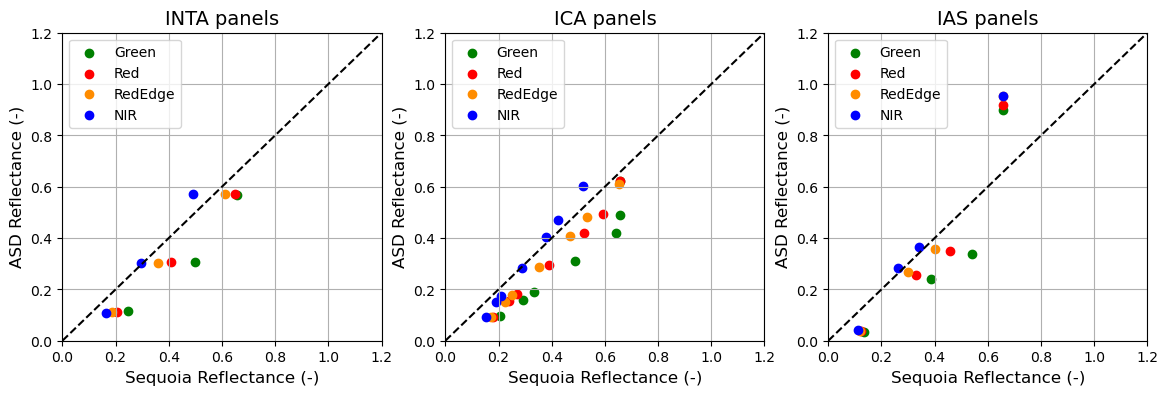

In [10]:
panel_groups = ['INTA', 'ICA', 'IAS']
colors = ['g', 'r', 'darkorange', 'blue']

# create 1x3 plot with each panel group 
fig, axes = plt.subplots(1,3, figsize=(14,4))
i = 0
for group in panel_groups:
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # get asd data for particular group of pabels and round 1
    asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
    uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
    # intialize axis
    ax = axes[i]
    b = 0
    # plot for each band
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        uav_values = uav_data[f'B{b+1}_val'].values
        ax.scatter(uav_values, asd_values, color=colors[b],label = band, marker='o')
        b = b + 1
        
    ax.grid(True)
    ax.plot([0, 1.2], [0, 1.2], color='black', linestyle='--')
    ax.legend()
    # intialize axis
    ax = axes[i]
    ax.set_title(f'{group} panels', fontsize=14)
    ax.set_xlabel('Sequoia Reflectance (-)', fontsize=12)
    ax.set_xlim(0, 1.2)
    ax.set_ylabel('ASD Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    i = i +1 
plt.show()
  


## 4.2 Calibrating image reflectance 

We will calibrate the UAV images using the empirical line approach using the reference panels.

> $\rho_{cal}$ = **gain** ($\rho_{original}$) + **offset**

When we have three or more references (e.g. panels), then we perform the calibration by fitting a linear regression model
### 4.2.1 Fit linear models

In [11]:
# use dictonary to store of empirical model parameters
lm_dict = {}

for group in panel_groups:
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # get asd data for particular group of pabels and round 1
    asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
    uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
    
    # initialize empty dictionary for each panel group to store results
    lm_dict[group] = {}
    # go through each band and develop linear model
    b = 0 
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        uav_values = uav_data[f'B{b+1}_val'].values
        lm = linregress(uav_values, asd_values)
        gain = lm.slope 
        offset = lm.intercept 
        r2 = lm.rvalue ** 2
        # store result as list of [gain, offset, r2]
        lm_dict[group][band] = [gain, offset, r2]
        b = b + 1

# convert dict to INTA panels
inta_df = pd.DataFrame(lm_dict['INTA'])
inta_df.index = ['gain', 'offset', 'R2']
print('\nINTA panels\n-----------')
print(inta_df)
# convert dict to ICA panels
ica_df = pd.DataFrame(lm_dict['ICA'])
ica_df.index = ['gain', 'offset', 'R2']
print('\nICA panels\n----------')
print(ica_df)
# convert dict to IAS panels
ias_df = pd.DataFrame(lm_dict['IAS'])
ias_df.index = ['gain', 'offset', 'R2']
print('\nIAS panels\n----------')
print(ias_df)



INTA panels
-----------
           Green       Red   RedEdge       NIR
gain    1.070112  1.036897  1.092643  1.404008
offset -0.170336 -0.106207 -0.092278 -0.118106
R2      0.949013  0.998164  0.999818  0.999936

ICA panels
----------
           Green       Red   RedEdge       NIR
gain    0.965724  1.041123  1.072131  1.379550
offset -0.124265 -0.100186 -0.090740 -0.115074
R2      0.908634  0.988361  0.999948  0.999887

IAS panels
----------
           Green       Red   RedEdge       NIR
gain    1.437406  1.598422  1.711457  1.689154
offset -0.237875 -0.234416 -0.227894 -0.167989
R2      0.773403  0.904951  0.958966  0.994864


### 4.2.2 Visualize linear models

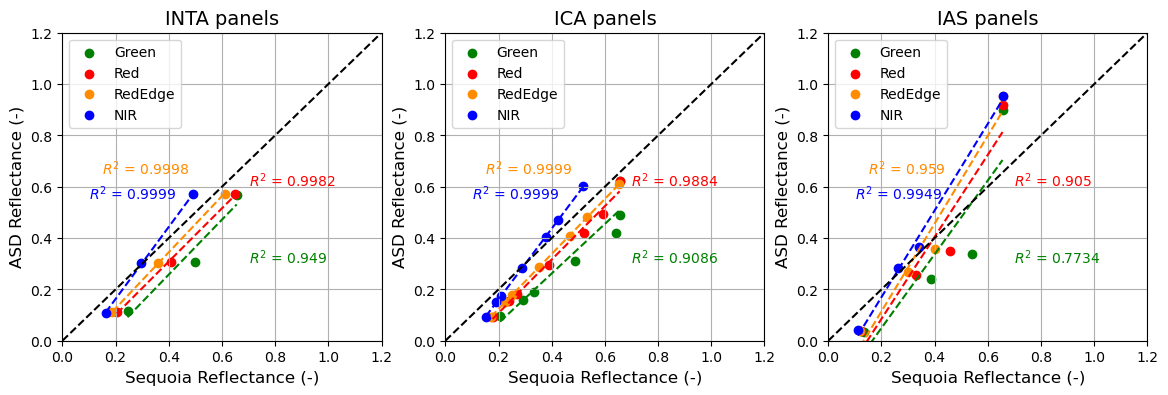

In [12]:
panel_groups = ['INTA', 'ICA', 'IAS']
colors = ['g', 'r', 'darkorange', 'blue']

# create 1x3 plot with each panel group 
fig, axes = plt.subplots(1,3, figsize=(14,4))
i = 0
for group in panel_groups:
    # get linear model parameters associated to each group
    lm_panels = lm_dict[group]
    
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # get asd data for particular group of pabels and round 1
    asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
    uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
    # intialize axis
    ax = axes[i]
    b = 0
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        uav_values = uav_data[f'B{b+1}_val'].values
        ax.scatter(uav_values, asd_values, color=colors[b],label = band, marker='o')
        # get lm params
        gain = lm_panels[band][0]
        offset = lm_panels[band][1]
        r2 = lm_panels[band][2]
        # plot linear regression
        x_lm = (np.min(uav_values), np.max(uav_values))
        y_lm = (gain*np.min(uav_values) + offset, gain*np.max(uav_values)+offset)
        ax.plot(x_lm, y_lm, color=colors[b], linestyle = '--')
        b = b + 1
        
    # get r2 for each bands
    r2_green = lm_panels['Green'][2]
    r2_red = lm_panels['Red'][2]
    r2_rededge = lm_panels['RedEdge'][2]
    r2_nir = lm_panels['NIR'][2]
    
    # annotate r2 over figure
    ax.text(0.7, 0.3, f'$R^2$ = {np.round(r2_green,4)}', color=colors[0])
    ax.text(0.7, 0.6, f'$R^2$ = {np.round(r2_red,4)}', color=colors[1])
    ax.text(0.15, 0.65, f'$R^2$ = {np.round(r2_rededge,4)}', color=colors[2])
    ax.text(0.1, 0.55, f'$R^2$ = {np.round(r2_nir,4)}', color=colors[3])

    ax.grid(True)
    ax.plot([0, 1.2], [0, 1.2], color='black', linestyle='--')
    ax.legend()
    # intialize axis
    ax = axes[i]
    ax.set_title(f'{group} panels', fontsize=14)
    ax.set_xlabel('Sequoia Reflectance (-)', fontsize=12)
    ax.set_xlim(0, 1.2)
    ax.set_ylabel('ASD Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    i = i +1 
plt.show()

# 5. Calibrate image with developed empirical model

Apply developed empirical line on each band of UAV image

In [13]:
# open uav image as gdal object
fid = gdal.Open(str(mosaic_file))

# get geotransform data
geotransform = fid.GetGeoTransform()
proj = fid.GetProjection()
minx, maxy = geotransform[0], geotransform[3]
maxx = minx + geotransform[1] * fid.RasterXSize
miny = maxy + geotransform[5] * fid.RasterYSize

# get metadata of image
num_bands = fid.RasterCount 
template_ar = fid.GetRasterBand(1).ReadAsArray()
rows, cols = template_ar.shape

# Read specific bands of uncalibrated image (4=NIR, 3=Red-Edge,2=Red and 1=Green)
nir_band = fid.GetRasterBand(4).ReadAsArray()  # Near-Infrared
rededge_band = fid.GetRasterBand(3).ReadAsArray()  # Red-edge
red_band = fid.GetRasterBand(2).ReadAsArray()  # Red
green_band = fid.GetRasterBand(1).ReadAsArray()  # Green

# initiazline empty 3D array with same number of bands 
ar_inta_cal = np.full((rows, cols, num_bands), np.nan)
ar_ica_cal = np.full((rows, cols, num_bands), np.nan)
ar_ias_cal = np.full((rows, cols, num_bands), np.nan)


for band in range(num_bands):
    ar = fid.GetRasterBand(band+1).ReadAsArray()
    # get band name in string
    band_name = band_names[band]
    # inta LM/EL parameters
    gain, offset = lm_dict['INTA'][band_name][:2]
    # calibrate based on INTA reference panels
    ar_inta_cal[:,:,band] = (gain*ar) + offset
    # ica LM/EL parameters
    gain, offset = lm_dict['ICA'][band_name][:2]
    # calibrate based on ICA reference panels
    ar_ica_cal[:,:,band] = (gain*ar) + offset
    # ias LM/EL parameters
    gain, offset = lm_dict['IAS'][band_name][:2]
    # calibrate based on IAS reference panels
    ar_ias_cal[:,:,band] = (gain*ar) + offset

# save calibrated images as geotiffs
panel_groups = ['INTA', 'ICA', 'IAS']
for group in panel_groups:
    outfilename = mosaic_file.name[:-4] + f'_EL_{group}panels.tif'
    outfile = uav_dir / outfilename
    driver = gdal.GetDriverByName('GTiff')
    nbands = ar_inta_cal.shape[2]
    
    ds = driver.Create(str(outfile), cols, rows, nbands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    ds.SetProjection(proj)
    input_nodata = np.nan
    if group == 'INTA':
        ar_img = ar_inta_cal
    elif group == 'ICA':
        ar_img = ar_ica_cal
    else:
        ar_img = ar_ias_cal


    for i in range(nbands):
        band = ds.GetRasterBand(i+1)
        band.SetNoDataValue(input_nodata)
        array = ar_img[:,:,i]
        array[np.isnan(array)] = input_nodata
        band.WriteArray(array)
        band.FlushCache()
    
    ds.FlushCache()
    ds = None
    print(f'Calibrated image using {group} panels saved as {str(outfile)}')


Calibrated image using INTA panels saved as dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_EL_INTApanels.tif
Calibrated image using ICA panels saved as dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_EL_ICApanels.tif
Calibrated image using IAS panels saved as dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_EL_IASpanels.tif


## 5.1 Visual comparison of calibrated vs original images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17033567908535457..0.8020110676954098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12426529427999683..0.789014238284264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23787500432915853..0.9389982229691096].


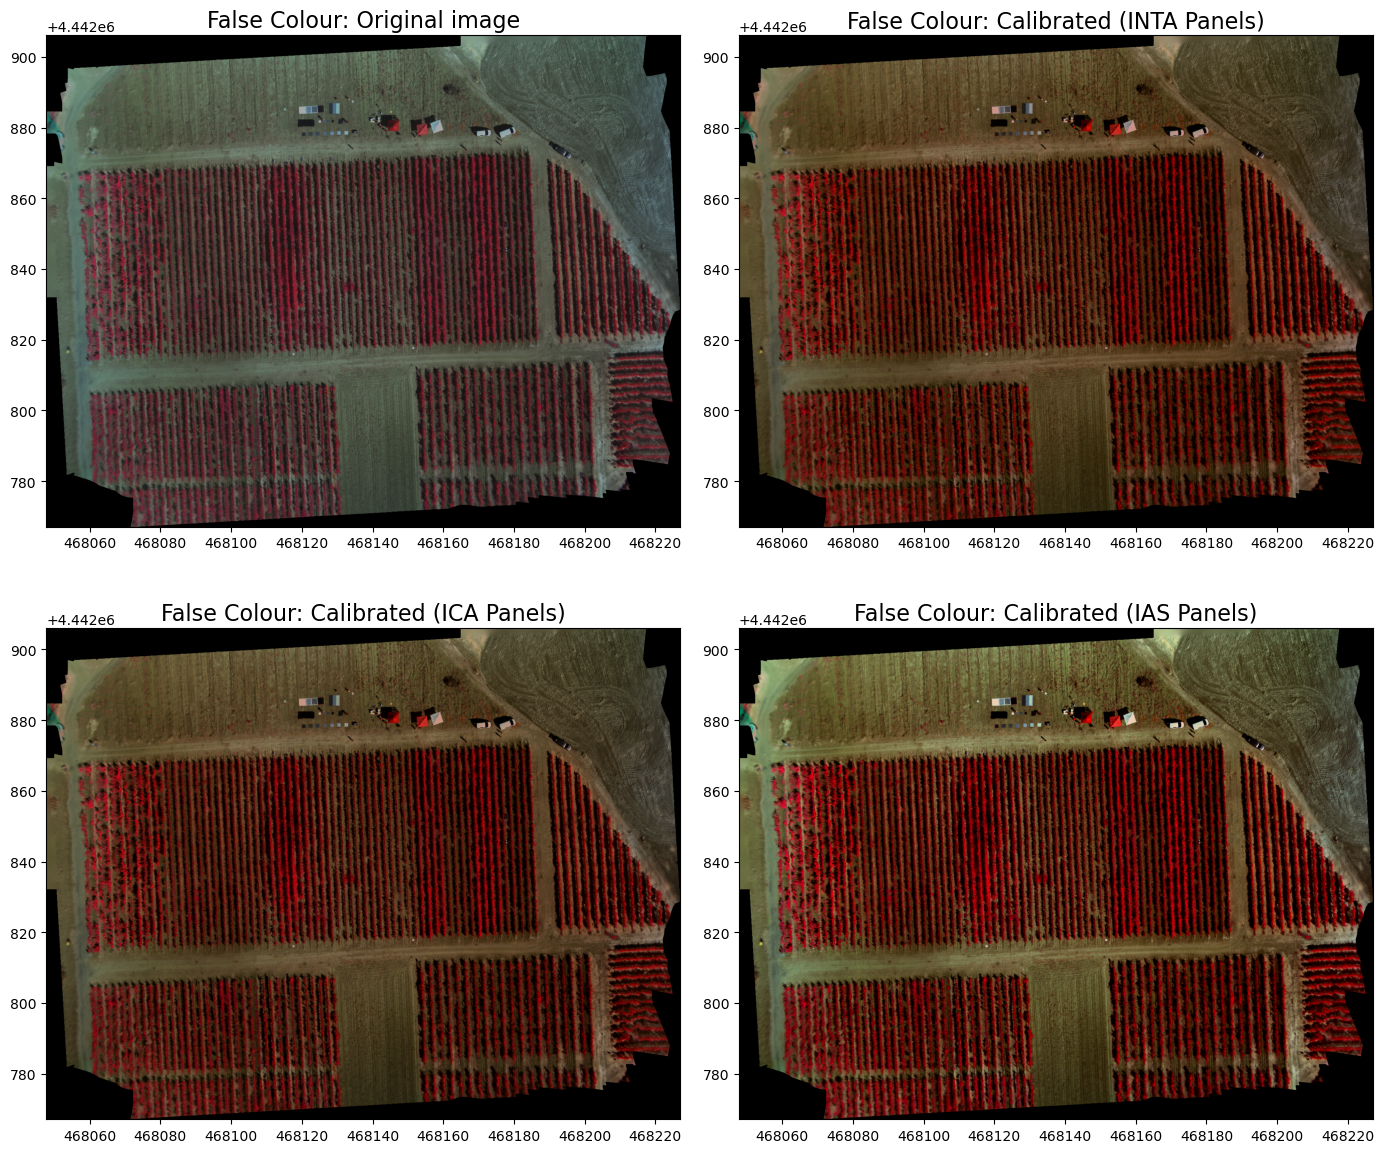

In [14]:
# Stack the calibrated bands to obtain false colour
false_color_inta = np.dstack((ar_inta_cal[:,:,3], ar_inta_cal[:,:,1],  ar_inta_cal[:,:,0]))
false_color_ica = np.dstack((ar_ica_cal[:,:,3], ar_ica_cal[:,:,1],  ar_ica_cal[:,:,0]))
false_color_ias = np.dstack((ar_ias_cal[:,:,3], ar_ias_cal[:,:,1],  ar_ias_cal[:,:,0]))

# Stack the uncalcalibrated bands to obtain false colour
false_color_uncal = np.dstack((nir_band, red_band,  green_band))

# make side by side false colour figure
fig, axes = plt.subplots(2,2, figsize=(14,12))
# calibrated with INTA panels
ax1 = axes[0,0]
ax1.imshow(false_color_uncal, extent=[minx, maxx, miny, maxy])
ax1.set_title('False Colour: Original image', fontsize=16)

ax2 = axes[0,1]
ax2.imshow(false_color_inta, extent=[minx, maxx, miny, maxy])
ax2.set_title('False Colour: Calibrated (INTA Panels)', fontsize=16)

# calibrated with ICA panels
ax3 = axes[1,0]
ax3.imshow(false_color_ica, extent=[minx, maxx, miny, maxy])
ax3.set_title('False Colour: Calibrated (ICA Panels)', fontsize=16)

# calibrated with IAS panels
ax4 = axes[1,1]
ax4.imshow(false_color_ias, extent=[minx, maxx, miny, maxy])
ax4.set_title('False Colour: Calibrated (IAS Panels)',fontsize=16)

plt.tight_layout()
#ax2.set_xlim(468115,468140)
#ax2.set_ylim(4442870,4442890)
plt.show()


## 5.2 Evaluate calibrated images against ASD data 
### 5.2.1 extract calibrated UAV data over reference panels

In [15]:
# create empty dictionary to store results 
values_dict = {} 


# radius in m
radius = 0.25 # in 25cm
for group in panel_groups:
    # get calibrated images
    img_file = uav_dir / f'Mosaic_REF_Sequoia_ICA_0942_EL_{group}panels.tif'
    fid = gdal.Open(str(img_file))
    
    i = 0
    for point in panels_gdf.geometry:
        id_point = panels_gdf['code'][i]
        x_coord = point.x 
        y_coord = point.y 
        
        # Convert geographic coordinates to local raster coordinates
        x = int((x_coord - geotransform[0]) / geotransform[1])
        y = int((y_coord - geotransform[3]) / geotransform[5])

        # only add point IDs once
        if group == 'INTA':
            # add panel id to output dictionary
            if 'panel_id' in values_dict:
                values_dict['panel_id'].append(id_point)
            else:
                values_dict['panel_id'] = []
                values_dict['panel_id'].append(id_point)
    
        i = i + 1
        for b in range(num_bands):
            band = fid.GetRasterBand(b+1)
            
            # convert radius from meter to pixels
            radius_pixel = int(radius / geotransform[1])
            # extract array values within radius
            raster_values = band.ReadAsArray(x - radius_pixel, y - radius_pixel,
                                                 radius_pixel * 2 + 1,
                                                 radius_pixel * 2 + 1)
            band_value = np.nanmean(raster_values)
            col_id = f'B{b+1}_{group}'
            if col_id in values_dict:
                values_dict[col_id].append(band_value)
            else:
                values_dict[col_id] = []
                values_dict[col_id].append(band_value) 
    
# transform output dictionary into pandas dataframe
uav_cal_values_df = pd.DataFrame(values_dict) 
uav_cal_values_df.head()

panel_id   B1_INTA   B2_INTA   B3_INTA   B4_INTA    B1_ICA    B2_ICA  \
0     ICA1  0.530961  0.573323  0.620497  0.609939  0.508621  0.582112   
1     ICA2  0.530960  0.508482  0.489914  0.478250  0.508620  0.517007   
2     ICA3  0.514456  0.433912  0.420563  0.412214  0.493726  0.442133   
3     ICA4  0.352242  0.296829  0.292419  0.284696  0.347335  0.304492   
4     ICA5  0.185823  0.173725  0.180805  0.177713  0.197150  0.180886   

     B3_ICA    B4_ICA    B1_IAS    B2_IAS    B3_IAS    B4_IAS  
0  0.608653  0.600288  0.704128  0.813109  0.888558  0.707917  
1  0.480522  0.470893  0.704127  0.713153  0.684020  0.549483  
2  0.412473  0.406008  0.681958  0.598201  0.575392  0.470036  
3  0.286735  0.280711  0.464067  0.386882  0.374675  0.316619  
4  0.177216  0.175592  0.240528  0.197112  0.199849  0.187909

### 5.2.2 plot calibrated UAV reflectance against ASD data

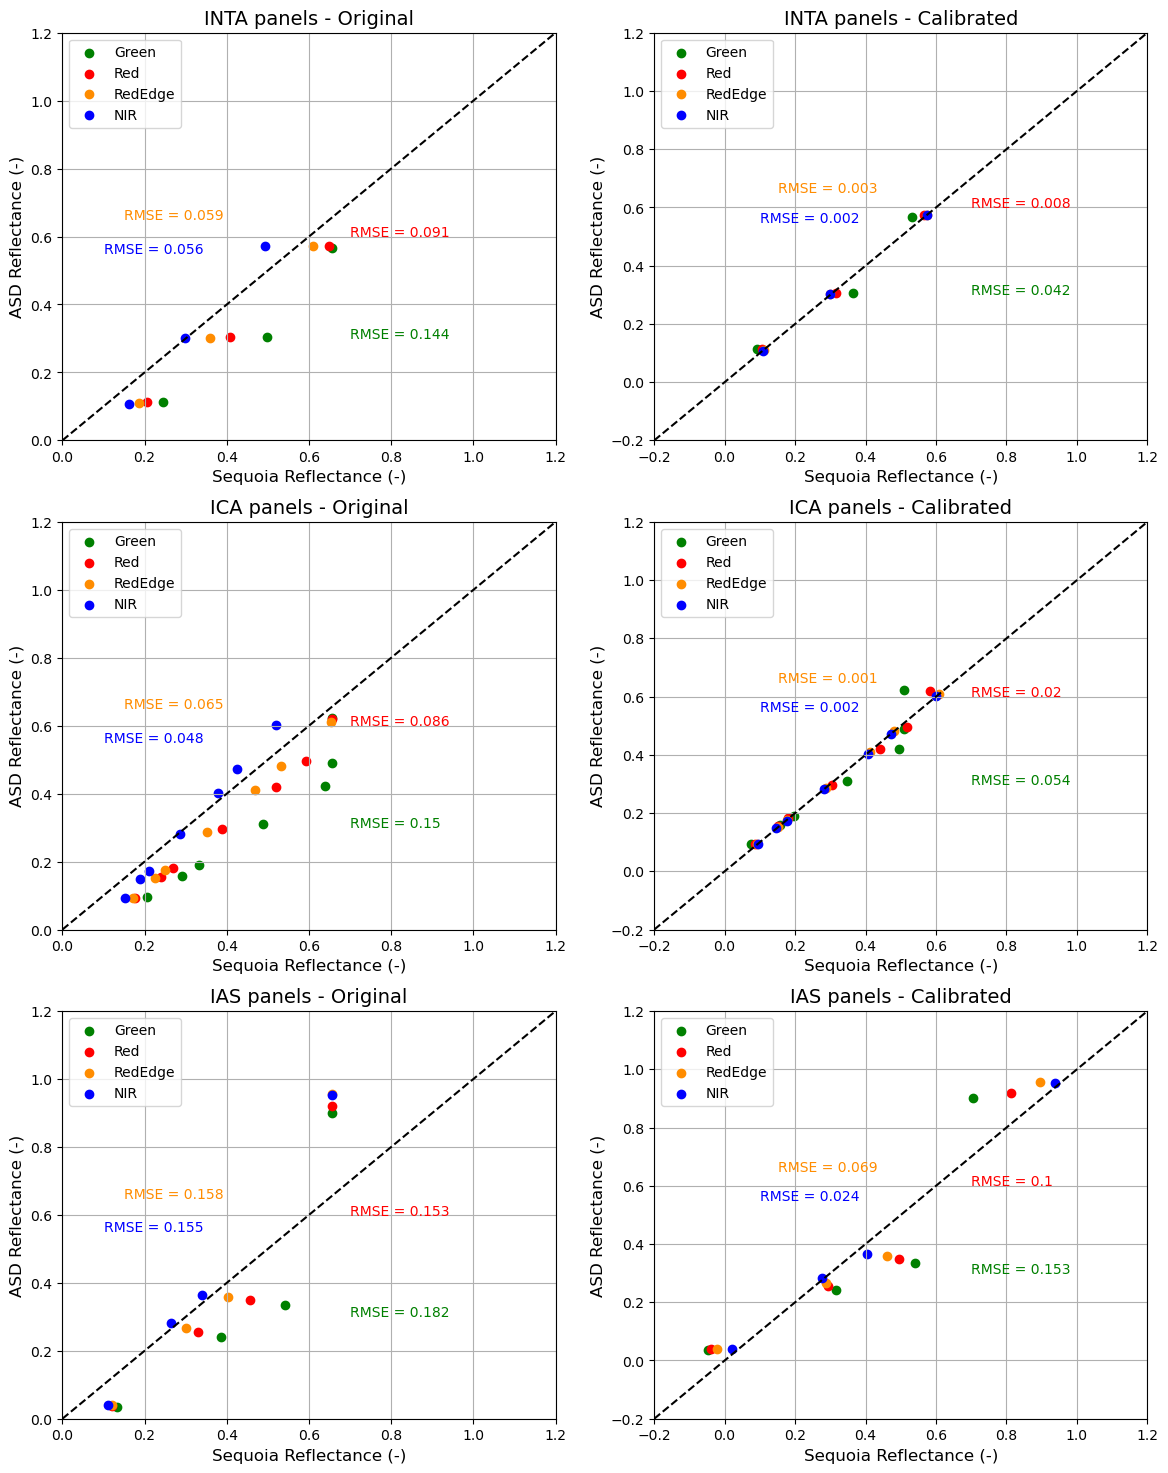

In [16]:
# function to calculate RMSE
def calc_rmse(obs, pred):
    rmse = np.sqrt(np.nanmean((pred - obs) ** 2))
    return rmse

panel_groups = ['INTA', 'ICA', 'IAS']
colors = ['g', 'r', 'darkorange', 'blue']

# create 1x3 plot with each panel group 
fig, axes = plt.subplots(3,2, figsize=(14,18))
i = 0
for group in panel_groups:
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # get asd data for particular group of pabels and round 1
    asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
    # original UAV data over panels
    uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
    # calibrated UAV data over panels
    cal_data = uav_cal_values_df[uav_cal_values_df['panel_id'].str.contains(group)] 
    # intialize axis
    ax = axes[i,0]
    b = 0
    rmse_og = []
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        uav_values = uav_data[f'B{b+1}_val'].values
        rmse = calc_rmse(asd_values, uav_values)
        rmse_og.append(rmse)
        ax.scatter(uav_values, asd_values, color=colors[b],label = band, marker='o')
        b = b + 1

    ax.text(0.7, 0.3, f'RMSE = {np.round(rmse_og[0],3)}', color=colors[0])
    ax.text(0.7, 0.6, f'RMSE = {np.round(rmse_og[1],3)}', color=colors[1])
    ax.text(0.15, 0.65, f'RMSE = {np.round(rmse_og[2],3)}', color=colors[2])
    ax.text(0.1, 0.55, f'RMSE = {np.round(rmse_og[3],3)}', color=colors[3])
    
    ax.grid(True)
    ax.plot([0, 1.2], [0, 1.2], color='black', linestyle='--')
    ax.legend()
    ax.set_title(f'{group} panels - Original', fontsize=14)
    ax.set_xlabel('Sequoia Reflectance (-)', fontsize=12)
    ax.set_xlim(0, 1.2)
    ax.set_ylabel('ASD Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)

    ax2 = axes[i,1]
    b = 0
    rmse_cal = []
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        cal_values = cal_data[f'B{b+1}_{group}'].values
        rmse = calc_rmse(asd_values, cal_values)
        rmse_cal.append(rmse)
        ax2.scatter(cal_values, asd_values, color=colors[b],label = band, marker='o')
        b = b + 1

    ax2.text(0.7, 0.3, f'RMSE = {np.round(rmse_cal[0],3)}', color=colors[0])
    ax2.text(0.7, 0.6, f'RMSE = {np.round(rmse_cal[1],3)}', color=colors[1])
    ax2.text(0.15, 0.65, f'RMSE = {np.round(rmse_cal[2],3)}', color=colors[2])
    ax2.text(0.1, 0.55, f'RMSE = {np.round(rmse_cal[3],3)}', color=colors[3])
    
    ax2.grid(True)
    ax2.plot([-0.2, 1.2], [-0.2, 1.2], color='black', linestyle='--')
    ax2.legend()
    ax2.set_title(f'{group} panels - Calibrated', fontsize=14)
    ax2.set_xlabel('Sequoia Reflectance (-)', fontsize=12)
    ax2.set_xlim(-0.2, 1.2)
    ax2.set_ylabel('ASD Reflectance (-)', fontsize=12)
    ax2.set_ylim(-0.2, 1.2)
    ax2.grid(True)
    i = i +1 
plt.show()
  


# 6. Next Steps?

- evaluate different multispectral sensors
- evaluate different sensor types (TIR, Hyperspectral)
- individual tile vs orthomosaic
- homogeneity analysis of panels
- best method to extract UAV data over panels? Radius (square, circle)? what size?
- timing of ASD measurements (round 1 vs round 2 vs round 3)
- number of panels to use?
- other??